In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import os
import torch
import torch.nn.functional as F
from rdkit import Chem
import matplotlib.pyplot as plt

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import global_mean_pool, global_max_pool
%matplotlib inline

In [2]:
gpuid = 0
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

0


In [3]:
import sys
sys.path.insert(0, '/home/was966/Research/bidd-clsar/')

In [4]:
from clsar.dataset import LSSNS, HSSMS
from clsar.feature import Gen39AtomFeatures
from clsar.model.model import ACANet_PNA, get_deg, _fix_reproducibility,ACANet_GAT, ACANet_GCN, ACANet_GIN
from clsar.model.loss import ACALoss, get_best_cliff
_fix_reproducibility(42)

In [5]:
ACANET_MODEL = ACANet_GIN

In [6]:
def train(train_loader, model, optimizer, aca_loss):

    total_examples = 0
    total_loss =  0    
    total_tsm_loss = 0
    total_reg_loss = 0   
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index, 
                                        data.edge_attr, data.batch)
        
        loss_out = aca_loss(labels = data.y, 
                            predictions = predictions,
                            embeddings = embeddings)
        loss, reg_loss, tsm_loss, n, n_pos = loss_out
        
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs        
        total_reg_loss += float(reg_loss) * data.num_graphs        
        total_examples += data.num_graphs
        
        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))
        
    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets

@torch.no_grad()
def test(test_loader, model, aca_loss):
    model.eval()
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    for i, data in enumerate(test_loader):
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse



def Test_performance(alpha=1.0):
    
    
    model = ACANET_MODEL(**pub_args, train_eps = True).to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
    aca_loss = ACALoss(alpha=alpha, squared = True, cliff_lower = 1., cliff_upper = 1.)
    
    history = []
    #ls_his = []
    for epoch in range(1, epochs):
        train_loss, tsm_loss, reg_loss, n_triplets, n_pos_triplets = train(train_loader, model, optimizer, aca_loss)

        _, _, _, _, train_n_pos_triplets, train_rmse = test(train_loader, model, aca_loss)
        _, _, _, _, val_n_pos_triplets, val_rmse = test(val_loader, model, aca_loss)
        _, _, _, _, test_n_pos_triplets, test_rmse = test(test_loader, model, aca_loss)

        
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f} tsm_loss: {tsm_loss:.4f} reg_loss: {reg_loss:.4f} '
              f'n_pos_triplets: {n_pos_triplets:03d};  Val: {val_rmse:.4f} Test: {test_rmse:.4f}')
    
        history.append({'Epoch':epoch, 'train_loss':train_loss, 'train_triplet_loss':tsm_loss,'train_mae_loss':reg_loss,
                        'val_rmse':val_rmse, 'test_rmse':test_rmse, 'train_rmse':train_rmse,'n_triplets': n_triplets, 
                        'n_pos_triplets':n_pos_triplets, 
                        'train_n_pos_triplets':train_n_pos_triplets,
                        'val_n_pos_triplets':val_n_pos_triplets,
                        'test_n_pos_triplets':test_n_pos_triplets,
                       
                       })
        #ls_his.append({'Epoch':epoch, 'mae_loss':float(mae_loss), 'triplet_loss':float(triplet_loss)})
    dfh = pd.DataFrame(history)
    return dfh

In [7]:
dataset_name = 'CHEMBL3979_EC50'
Dataset =  HSSMS #LSSNS 
epochs = 800
batch_size = 128
lr = 1e-4

pre_transform = Gen39AtomFeatures()
in_channels = pre_transform.in_channels
path = '../data/'

## model HPs
pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'convs_layers': [64, 128, 256, 512],   
            'dense_layers': [256, 128, 32], 
            'out_channels':1, 
            # 'aggregators': ['mean', 'min', 'max', 'sum','std'],
            # 'scalers':['identity', 'amplification', 'attenuation'] ,
            'dropout_p': 0}

In [8]:
len(Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42))

1125

In [9]:
# train, valid, test splitting
res1 = []
res2 = []
for seed in [8, 16, 24, 42, 64, 128, 256, 512, 1024, 2048]:
    dataset = Dataset(path, name=dataset_name, pre_transform=pre_transform).shuffle(42)
    N = len(dataset) // 5
    val_dataset = dataset[:N]
    test_dataset = dataset[N:2 * N]
    train_dataset = dataset[2 * N:]
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    deg = get_deg(train_dataset)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # With AC-Awareness ($\alpha = 1$)
    df1 = Test_performance(alpha=1.0)
    df1['seed'] = seed
    # Without AC-Awareness ($\alpha = 0$)
    df2 = Test_performance(alpha=0.0)
    df2['seed'] = seed
    res1.append(df1)
    res2.append(df2)

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 637.2007 tsm_loss: 592.1956 reg_loss: 45.0051 n_pos_triplets: 196333;  Val: 6.6330 Test: 6.6544
Epoch: 002, Loss: 479.2252 tsm_loss: 439.7017 reg_loss: 39.5234 n_pos_triplets: 191307;  Val: 6.5977 Test: 6.6185
Epoch: 003, Loss: 364.8150 tsm_loss: 332.2039 reg_loss: 32.6111 n_pos_triplets: 186822;  Val: 6.4179 Test: 6.4348
Epoch: 004, Loss: 303.3028 tsm_loss: 279.4054 reg_loss: 23.8974 n_pos_triplets: 181226;  Val: 5.9249 Test: 5.9367
Epoch: 005, Loss: 240.5774 tsm_loss: 226.2679 reg_loss: 14.3095 n_pos_triplets: 180479;  Val: 4.9414 Test: 4.9498
Epoch: 006, Loss: 213.8211 tsm_loss: 207.7979 reg_loss: 6.0232 n_pos_triplets: 178598;  Val: 3.4506 Test: 3.4562
Epoch: 007, Loss: 174.4122 tsm_loss: 172.5985 reg_loss: 1.8136 n_pos_triplets: 176181;  Val: 1.8759 Test: 1.8728
Epoch: 008, Loss: 154.9026 tsm_loss: 152.7686 reg_loss: 2.1340 n_pos_triplets: 172799;  Val: 1.2156 Test: 1.1980
Epoch: 009, Loss: 142.3603 tsm_loss: 140.0098 reg_loss: 2.3505 n_pos_triplets: 168730;  Val

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 42.5621 tsm_loss: 1069.0568 reg_loss: 42.5621 n_pos_triplets: 198273;  Val: 6.5699 Test: 6.5894
Epoch: 002, Loss: 37.2550 tsm_loss: 1028.5209 reg_loss: 37.2550 n_pos_triplets: 198520;  Val: 6.5190 Test: 6.5384
Epoch: 003, Loss: 31.4328 tsm_loss: 960.5385 reg_loss: 31.4328 n_pos_triplets: 196225;  Val: 6.3495 Test: 6.3680
Epoch: 004, Loss: 24.3177 tsm_loss: 884.8494 reg_loss: 24.3177 n_pos_triplets: 193307;  Val: 5.9470 Test: 5.9643
Epoch: 005, Loss: 15.9579 tsm_loss: 846.5087 reg_loss: 15.9579 n_pos_triplets: 193376;  Val: 5.1728 Test: 5.1873
Epoch: 006, Loss: 8.0118 tsm_loss: 761.9478 reg_loss: 8.0118 n_pos_triplets: 190774;  Val: 3.9643 Test: 3.9705
Epoch: 007, Loss: 2.6828 tsm_loss: 647.6929 reg_loss: 2.6828 n_pos_triplets: 186767;  Val: 2.5204 Test: 2.5070
Epoch: 008, Loss: 1.6597 tsm_loss: 537.7578 reg_loss: 1.6597 n_pos_triplets: 185181;  Val: 1.5248 Test: 1.4672
Epoch: 009, Loss: 1.7896 tsm_loss: 491.2542 reg_loss: 1.7896 n_pos_triplets: 179455;  Val: 1.2696 Te

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 896.4519 tsm_loss: 851.4727 reg_loss: 44.9792 n_pos_triplets: 196818;  Val: 6.6598 Test: 6.6294
Epoch: 002, Loss: 686.0957 tsm_loss: 644.8478 reg_loss: 41.2479 n_pos_triplets: 193344;  Val: 6.6108 Test: 6.5793
Epoch: 003, Loss: 534.1374 tsm_loss: 497.1154 reg_loss: 37.0220 n_pos_triplets: 190230;  Val: 6.5192 Test: 6.4858
Epoch: 004, Loss: 441.8057 tsm_loss: 410.2287 reg_loss: 31.5770 n_pos_triplets: 185537;  Val: 6.2847 Test: 6.2467
Epoch: 005, Loss: 359.0426 tsm_loss: 334.1859 reg_loss: 24.8567 n_pos_triplets: 183836;  Val: 5.8253 Test: 5.7809
Epoch: 006, Loss: 313.1701 tsm_loss: 295.8654 reg_loss: 17.3046 n_pos_triplets: 180769;  Val: 5.0684 Test: 5.0136
Epoch: 007, Loss: 247.1732 tsm_loss: 237.1882 reg_loss: 9.9850 n_pos_triplets: 173673;  Val: 4.0226 Test: 3.9561
Epoch: 008, Loss: 209.2422 tsm_loss: 205.1537 reg_loss: 4.0885 n_pos_triplets: 172802;  Val: 2.7775 Test: 2.7057
Epoch: 009, Loss: 188.8890 tsm_loss: 187.4322 reg_loss: 1.4568 n_pos_triplets: 169259;  Va

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 42.9799 tsm_loss: 623.5340 reg_loss: 42.9799 n_pos_triplets: 195273;  Val: 6.5648 Test: 6.5338
Epoch: 002, Loss: 38.6777 tsm_loss: 591.7861 reg_loss: 38.6777 n_pos_triplets: 196143;  Val: 6.5053 Test: 6.4731
Epoch: 003, Loss: 33.5221 tsm_loss: 568.6443 reg_loss: 33.5221 n_pos_triplets: 194545;  Val: 6.3403 Test: 6.3071
Epoch: 004, Loss: 26.9195 tsm_loss: 557.4849 reg_loss: 26.9195 n_pos_triplets: 196315;  Val: 5.9625 Test: 5.9284
Epoch: 005, Loss: 18.9090 tsm_loss: 544.7925 reg_loss: 18.9090 n_pos_triplets: 194099;  Val: 5.2690 Test: 5.2333
Epoch: 006, Loss: 10.4187 tsm_loss: 517.1376 reg_loss: 10.4187 n_pos_triplets: 192563;  Val: 4.2222 Test: 4.1862
Epoch: 007, Loss: 3.9363 tsm_loss: 507.2004 reg_loss: 3.9363 n_pos_triplets: 191350;  Val: 2.9052 Test: 2.8636
Epoch: 008, Loss: 1.6155 tsm_loss: 432.3429 reg_loss: 1.6155 n_pos_triplets: 188893;  Val: 1.8073 Test: 1.7285
Epoch: 009, Loss: 1.7581 tsm_loss: 371.1018 reg_loss: 1.7581 n_pos_triplets: 184925;  Val: 1.3378 Te

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Epoch: 793, Loss: 1.0793 tsm_loss: 0.9951 reg_loss: 0.0842 n_pos_triplets: 45219;  Val: 0.8054 Test: 0.7890
Epoch: 794, Loss: 1.1599 tsm_loss: 1.0688 reg_loss: 0.0911 n_pos_triplets: 45013;  Val: 0.7823 Test: 0.7622
Epoch: 795, Loss: 1.1086 tsm_loss: 1.0042 reg_loss: 0.1045 n_pos_triplets: 45741;  Val: 0.7776 Test: 0.7499
Epoch: 796, Loss: 1.1302 tsm_loss: 1.0464 reg_loss: 0.0837 n_pos_triplets: 45702;  Val: 0.7821 Test: 0.7571
Epoch: 797, Loss: 1.0543 tsm_loss: 0.9727 reg_loss: 0.0816 n_pos_triplets: 45132;  Val: 0.7828 Test: 0.7624
Epoch: 798, Loss: 1.1620 tsm_loss: 1.0667 reg_loss: 0.0953 n_pos_triplets: 46833;  Val: 0.7853 Test: 0.7652
Epoch: 799, Loss: 1.3037 tsm_loss: 1.2007 reg_loss: 0.1030 n_pos_triplets: 45368;  Val: 0.7856 Test: 0.7620


/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 40.7936 tsm_loss: 959.2721 reg_loss: 40.7936 n_pos_triplets: 198355;  Val: 6.5237 Test: 6.6144
Epoch: 002, Loss: 32.6887 tsm_loss: 923.5713 reg_loss: 32.6887 n_pos_triplets: 197110;  Val: 6.4464 Test: 6.5407
Epoch: 003, Loss: 23.5095 tsm_loss: 867.8967 reg_loss: 23.5095 n_pos_triplets: 196197;  Val: 6.1559 Test: 6.2603
Epoch: 004, Loss: 13.3213 tsm_loss: 784.4945 reg_loss: 13.3213 n_pos_triplets: 197028;  Val: 5.4176 Test: 5.5437
Epoch: 005, Loss: 5.1407 tsm_loss: 710.2696 reg_loss: 5.1407 n_pos_triplets: 197192;  Val: 4.0810 Test: 4.2369
Epoch: 006, Loss: 2.3147 tsm_loss: 614.9992 reg_loss: 2.3147 n_pos_triplets: 192491;  Val: 2.5459 Test: 2.7027
Epoch: 007, Loss: 2.5928 tsm_loss: 558.7255 reg_loss: 2.5928 n_pos_triplets: 190434;  Val: 1.7543 Test: 1.8626
Epoch: 008, Loss: 1.4290 tsm_loss: 508.8033 reg_loss: 1.4290 n_pos_triplets: 185771;  Val: 1.5584 Test: 1.6133
Epoch: 009, Loss: 0.9553 tsm_loss: 485.7419 reg_loss: 0.9553 n_pos_triplets: 182249;  Val: 1.5147 Test: 

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 742.5737 tsm_loss: 702.3702 reg_loss: 40.2035 n_pos_triplets: 189174;  Val: 6.4164 Test: 6.4902
Epoch: 002, Loss: 562.7018 tsm_loss: 529.3364 reg_loss: 33.3654 n_pos_triplets: 186423;  Val: 6.2727 Test: 6.3462
Epoch: 003, Loss: 448.7268 tsm_loss: 423.1346 reg_loss: 25.5922 n_pos_triplets: 181538;  Val: 5.9503 Test: 6.0193
Epoch: 004, Loss: 335.9218 tsm_loss: 319.4547 reg_loss: 16.4671 n_pos_triplets: 179243;  Val: 5.2414 Test: 5.3026
Epoch: 005, Loss: 276.0847 tsm_loss: 267.9179 reg_loss: 8.1668 n_pos_triplets: 178409;  Val: 4.0331 Test: 4.0837
Epoch: 006, Loss: 234.7292 tsm_loss: 232.1116 reg_loss: 2.6177 n_pos_triplets: 175573;  Val: 2.5591 Test: 2.5971
Epoch: 007, Loss: 205.6748 tsm_loss: 203.9893 reg_loss: 1.6854 n_pos_triplets: 174145;  Val: 1.5136 Test: 1.5391
Epoch: 008, Loss: 184.6483 tsm_loss: 182.3741 reg_loss: 2.2742 n_pos_triplets: 171480;  Val: 1.2598 Test: 1.2840
Epoch: 009, Loss: 159.0827 tsm_loss: 157.4478 reg_loss: 1.6350 n_pos_triplets: 167063;  Val:

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 42.5380 tsm_loss: 593.4499 reg_loss: 42.5380 n_pos_triplets: 195604;  Val: 6.5049 Test: 6.5786
Epoch: 002, Loss: 38.5325 tsm_loss: 602.2361 reg_loss: 38.5325 n_pos_triplets: 194192;  Val: 6.4669 Test: 6.5400
Epoch: 003, Loss: 33.8973 tsm_loss: 603.8957 reg_loss: 33.8973 n_pos_triplets: 194645;  Val: 6.3638 Test: 6.4346
Epoch: 004, Loss: 27.7054 tsm_loss: 605.0026 reg_loss: 27.7054 n_pos_triplets: 193770;  Val: 6.0867 Test: 6.1504
Epoch: 005, Loss: 20.0078 tsm_loss: 624.1063 reg_loss: 20.0078 n_pos_triplets: 192348;  Val: 5.4995 Test: 5.5523
Epoch: 006, Loss: 11.2965 tsm_loss: 620.9166 reg_loss: 11.2965 n_pos_triplets: 191192;  Val: 4.4953 Test: 4.5359
Epoch: 007, Loss: 4.3282 tsm_loss: 599.8752 reg_loss: 4.3282 n_pos_triplets: 189147;  Val: 3.1332 Test: 3.1682
Epoch: 008, Loss: 1.7125 tsm_loss: 526.4312 reg_loss: 1.7125 n_pos_triplets: 185960;  Val: 1.8781 Test: 1.9245
Epoch: 009, Loss: 1.7417 tsm_loss: 424.9057 reg_loss: 1.7417 n_pos_triplets: 182633;  Val: 1.3096 Te

/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/home/was966/micromamba/envs/responder/lib/python3.8/site-packages/torch_geometric/warnings.py:17: UserWarning: The usage of `scatter(reduce='max')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)


Epoch: 001, Loss: 838.2897 tsm_loss: 795.6911 reg_loss: 42.5985 n_pos_triplets: 194966;  Val: 6.6647 Test: 6.5377
Epoch: 002, Loss: 584.1383 tsm_loss: 546.6393 reg_loss: 37.4990 n_pos_triplets: 194434;  Val: 6.5888 Test: 6.4623
Epoch: 003, Loss: 470.1288 tsm_loss: 439.4215 reg_loss: 30.7074 n_pos_triplets: 189679;  Val: 6.4036 Test: 6.2753
Epoch: 004, Loss: 373.5701 tsm_loss: 350.9029 reg_loss: 22.6672 n_pos_triplets: 187590;  Val: 5.9556 Test: 5.8244
Epoch: 005, Loss: 304.3663 tsm_loss: 290.3761 reg_loss: 13.9903 n_pos_triplets: 182963;  Val: 5.0897 Test: 4.9583
Epoch: 006, Loss: 251.0933 tsm_loss: 244.8627 reg_loss: 6.2306 n_pos_triplets: 177798;  Val: 3.7699 Test: 3.6412
Epoch: 007, Loss: 213.7093 tsm_loss: 211.6841 reg_loss: 2.0252 n_pos_triplets: 177132;  Val: 2.3023 Test: 2.1943
Epoch: 008, Loss: 188.2362 tsm_loss: 186.2023 reg_loss: 2.0339 n_pos_triplets: 176092;  Val: 1.4713 Test: 1.4227
Epoch: 009, Loss: 166.1166 tsm_loss: 163.8614 reg_loss: 2.2552 n_pos_triplets: 170059;  Val

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
df1 = pd.concat(res1)
df2 = pd.concat(res2)

In [11]:
df1.to_csv('./with_aca.csv')
df2.to_csv('./without_aca.csv')

In [12]:
# df1 = pd.read_csv('./with_aca.csv', index_col = 0)
# df2 = pd.read_csv('./without_aca.csv', index_col = 0)

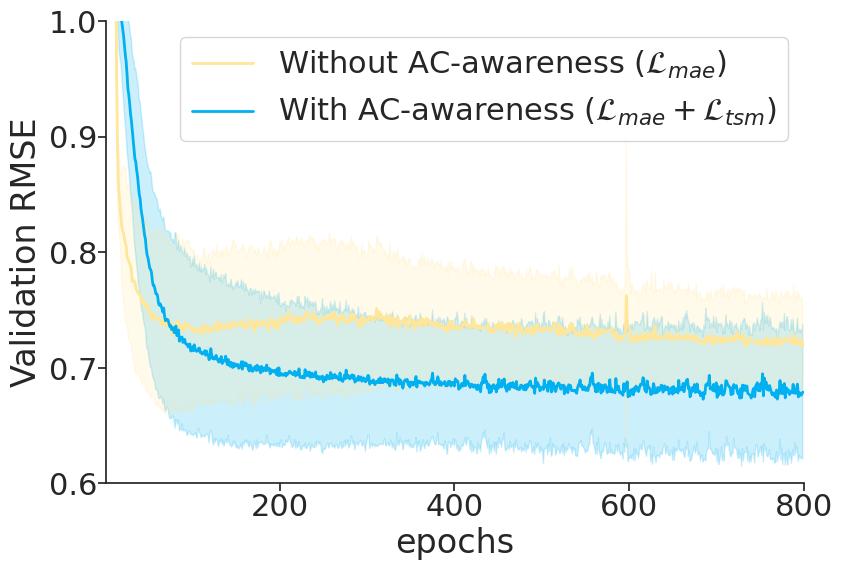

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'val_rmse'

n1 = r'With AC-awareness ($\mathcal{L}_{mae} + \mathcal{L}_{tsm}$)'
n2 = r'Without AC-awareness ($\mathcal{L}_{mae}$)'


dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1, legend=True)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Validation RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Validation_RMSE.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Validation_RMSE.pdf', bbox_inches='tight', dpi=400) 

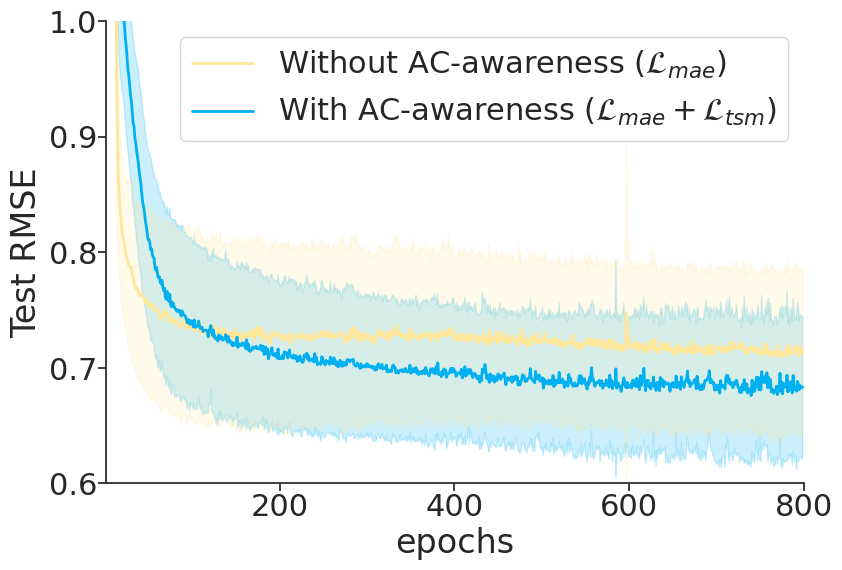

In [14]:
fig, ax = plt.subplots(figsize=(9, 6))
colors = ['#FFE699','#00B0F0']


y = 'test_rmse'



dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2, ax=ax,color = colors, alpha =1, legend=True)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.2)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.2)

ax.set_ylim(0.60, 1.0)
ax.set_ylabel('Test RMSE')
ax.set_xlabel('epochs')
ax.spines[['right', 'top']].set_visible(False)

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Test_RMSE.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Test_RMSE.pdf' , bbox_inches='tight', dpi=400) 

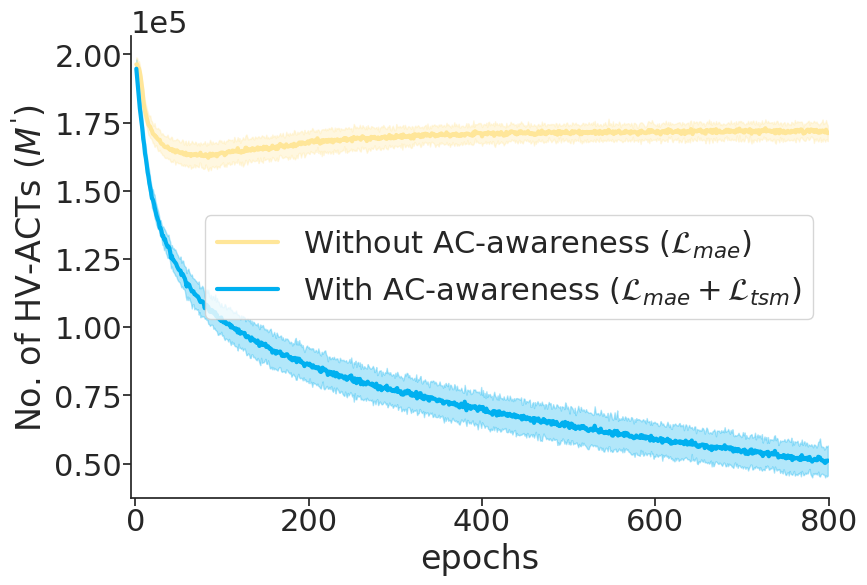

In [15]:
fig, ax = plt.subplots(figsize=(9, 6))


y = 'n_pos_triplets'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1, legend=True)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

#ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.spines[['right', 'top']].set_visible(False)

plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel("No. of HV-ACTs ($M^'$)")
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
ax.set_xlim(-5,800)

fig.savefig('./Number_of_mined_ACTs_during_training.svg' , bbox_inches='tight', dpi=400) 
fig.savefig('./Number_of_mined_ACTs_during_training.pdf' , bbox_inches='tight', dpi=400) 

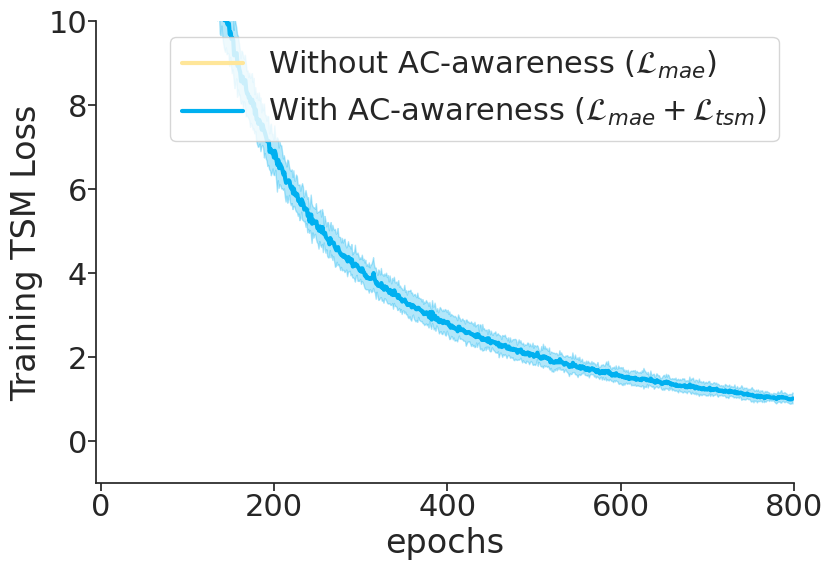

In [16]:
fig, ax = plt.subplots(figsize=(9, 6))
y = 'train_triplet_loss'
dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 3, ax=ax,color = colors, alpha =1, legend=True)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)

ax.spines[['right', 'top']].set_visible(False)
ax.set_xlim(-5,800)
ax.set_ylim(-1,10)

ax.set_ylabel('Training TSM Loss')
ax.set_xlabel('epochs')
ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Triplet_loss_during_training.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Triplet_loss_during_training.pdf', bbox_inches='tight', dpi=400) 

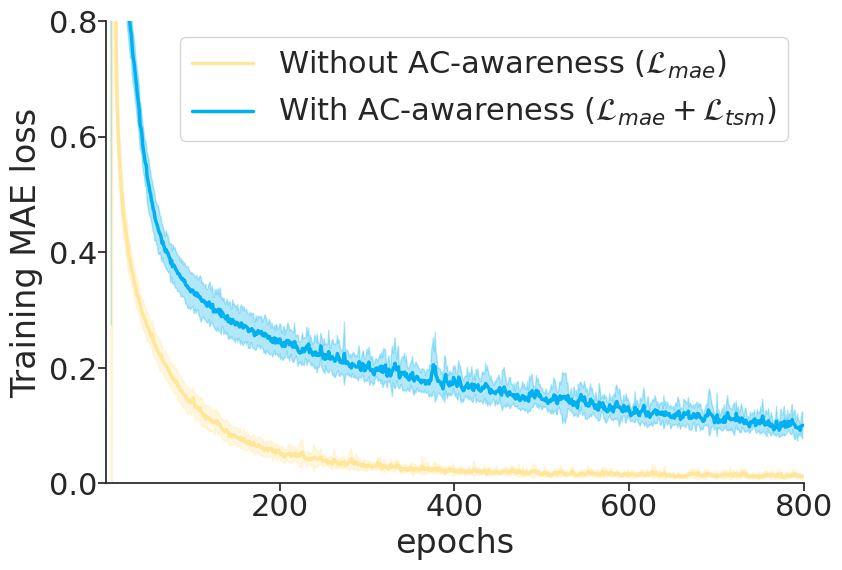

In [17]:
fig, ax = plt.subplots(figsize=(9, 6))

y = 'train_mae_loss'

dfp = df2.groupby('Epoch').mean()[y].to_frame(name = n2).join(df1.groupby('Epoch').mean()[y].to_frame(name = n1)).rolling(1).mean()
dfp_std = df2.groupby('Epoch').std()[y].to_frame(name = n2).join(df1.groupby('Epoch').std()[y].to_frame(name = n1)).rolling(1).mean()

dfp.plot(lw = 2.5, ax=ax,color = colors, alpha =1, legend=True)
ax.fill_between(dfp.index, (dfp - dfp_std)[n1], (dfp + dfp_std)[n1], color=colors[1], alpha=0.3)
ax.fill_between(dfp.index, (dfp - dfp_std)[n2], (dfp + dfp_std)[n2], color=colors[0], alpha=0.3)



ax.set_ylim(0.0, 0.8)
ax.spines[['right', 'top']].set_visible(False)


ax.set_ylabel('Training MAE loss')
ax.set_xlabel('epochs')
#ax.legend(loc='center', bbox_to_anchor=(0.55, 0.5))

ax.set_xlim(1,800)

ax.tick_params(left='off', labelleft='on', labelbottom='on', bottom = 'off',  pad=.5,)
fig.savefig('./Train_mae_los.svg', bbox_inches='tight', dpi=400) 
fig.savefig('./Train_mae_los.pdf', bbox_inches='tight', dpi=400) 